In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from DEPENDENCIES.constants import *
from scipy.stats import norm
import DEPENDENCIES.processing as proc
import DEPENDENCIES.plot_performance as pp
from scipy.stats import ks_2samp
Z = 18
from svg2emf import svg2emf

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [2]:
def read_text_file_pull(fname):
    f = open(fname, 'r')
    fl = f.readlines()
    f.close()
    
    data = []
    for line in fl[:-1]:
        if "@" not in line and "#" not in line:
            data.append(line.split())
    data = np.array(data, dtype='float')
    return data

In [3]:
def homogenize_pull(X, F, n_ignore=40):
    lens = [len(x) for x in X] + [len(f) for f in F]
    n_bottle = min(lens)
    times = X[0][:n_bottle,0]
    X = [x[:n_bottle,1:] for x in X]
    F = [f[:n_bottle,1:] for f in F]
    X = np.concatenate(X, axis=1)
    F = np.concatenate(F, axis=1)

    nice_x = np.linspace(np.min(X[:,1:]), np.max(X[:,1:]), 1000)
    #nice_x = np.linspace(1.5, 3.8, 1000)
    dx = nice_x[1] - nice_x[0]
    nice_f = []
    for i in range(len(X[0,:])):
        forces = []
        for x in nice_x:
            closest_ndx = np.argsort(np.abs(X[:,i] - x))[:2]
            if x<np.min(X[:,i]) or x>np.max(X[:,i]):
                forces.append(-1000)
            else:
                forces.append(np.mean(F[closest_ndx,i]))
        nice_f.append(forces)
    nice_f = np.array(nice_f).T 
    for i in range(len(nice_x)):
        mask = nice_f[i,:]!=-1000
        mean = np.mean(nice_f[i,mask])
        nice_f[i,~mask] = mean
    
    nice_g = []
    for f in nice_f.T:
        dg = np.cumsum(f*dx)
        nice_g.append(dg)
    nice_g = np.array(nice_g).T
    nice_g = (nice_g[n_ignore:-n_ignore] - nice_g[n_ignore:-n_ignore][-1])
    return nice_x[n_ignore:-n_ignore], nice_f[n_ignore:-n_ignore]/4.184, nice_g/4.184 #kJ to kcal"""

In [4]:
S = ["36","37"]
Xs_raw = [[read_text_file_pull("./S{}/PULLX/{}S{}_PULL_pullx.xvg".format(s, NA, s)) for s in S] for NA in DATA.index]
Fs_raw = [[read_text_file_pull("./S{}/PULLF/{}S{}_PULL_pullf.xvg".format(s, NA, s)) for s in S] for NA in DATA.index]

In [5]:
Xs, Fs, Gs = [], [], []
for n, NA in enumerate(DATA.index):
    print(n, NA)
    x, f, g = homogenize_pull(Xs_raw[n], Fs_raw[n])
    Xs.append(x)
    Fs.append(f)
    Gs.append(g)

0 N1A16
1 N1A17
2 N3A10
3 N3A11
4 N3A18
5 N15A20
6 N2A11
7 N2A10
8 N1A9
9 N1A8
10 N1A7
11 N1A13
12 N1A1
13 N3A19
14 N1A15
15 N1A12
16 N1A10
17 N1A14
18 N1A11
19 N2A18
20 N1A18
21 N2A19
22 N1A19


In [6]:
#DATA['Score'] = [proc.reject_outliers(np.abs(np.min(g, axis=0)), iq=1.5) for g in Gs]
DATA['Score'] = [proc.reject_outliers(np.abs(np.min(g, axis=0)), iq=1.5) for g in Gs]

#DATA['DG_Mean'] = DATA.Score.apply(np.mean) #mean
DATA['DG_Mean'] = DATA.Score.apply(proc.boltz_mean) #mean
#DATA['DG_Std'] = DATA.Score.apply(lambda x: np.std(x)/(len(x)**0.5)) #ste
DATA['DG_Std'] = DATA.Score.apply(proc.boltz_std) #ste

In [7]:
#Puts dyad number as index (for thesis plots)
DATA['System'] = DATA.index
#DATA.set_index(np.array(['r'+str(i) for i in np.linspace(31,1,31,dtype='int')]), inplace=True)
DATA.set_index(np.array(['r'+str(i) for i in np.linspace(23,1,23,dtype='int')]), inplace=True)

In [8]:
np.set_printoptions(threshold=100)
DATA.drop(['DG_Mean','DG_Std'], axis=1).to_csv("S36/DATA.csv")
np.set_printoptions(threshold=10)

In [9]:
DATA

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Score,DG_Mean,DG_Std,System
r23,1,16,0.0,0.0,22,0,4,0.000000,0.000000,0.000000,"[0.5, 0.0, 1.0, 1.0]",False,"[9.288041475872392, 4.282236978039926, 2.73936...",13.375058,0.608908,N1A16
r22,1,17,0.0,0.0,21,1,3,0.000000,0.000000,0.000000,"[0.41, 0.14, 1.0, 1.0]",False,"[4.550628335473629, 7.2270197983770075, 6.9246...",8.076251,0.564885,N1A17
r21,3,10,0.0,0.0,20,2,2,0.000000,0.000000,0.000000,"[0.32, 0.28, 0.99, 1.0]",False,"[8.825919849191028, 12.486030550199187, 9.7288...",16.294997,0.486322,N3A10
r20,3,11,0.0,0.0,19,3,1,0.000000,0.000000,0.000000,"[0.23, 0.41, 0.98, 1.0]",False,"[8.61962856575134, 8.266370530786512, 5.087257...",19.573103,0.318411,N3A11
r19,3,18,0.0,0.0,18,4,0,0.000000,0.000000,0.000000,"[0.14, 0.54, 0.96, 1.0]",False,"[9.178812658688003, 12.993237730165722, 14.755...",16.061781,0.714138,N3A18
r18,15,20,300.0,0.0,17,0,0,2.477121,0.000000,0.000000,"[0.05, 0.66, 0.94, 1.0]",True,"[6.093380671561805, 4.5388658465979415, 7.0610...",7.776249,0.726722,N15A20
r17,2,11,85000.0,15000.0,16,2,0,4.929419,0.070581,0.084321,"[0.04, 0.75, 0.91, 1.0]",True,"[16.313033785994197, 15.266570341583371, 11.10...",16.177794,0.466466,N2A11
r16,2,10,93000.0,12000.0,15,1,1,4.968483,0.052706,0.059998,"[0.14, 0.84, 0.88, 1.0]",True,"[8.787232067800229, 12.397592631713772, 14.193...",21.093548,0.438964,N2A10
r15,1,9,120000.0,20000.0,14,1,2,5.079181,0.066947,0.079181,"[0.23, 0.91, 0.84, 1.0]",True,"[13.288001067941005, 10.418017349372178, 14.50...",19.446542,0.326657,N1A9
r14,1,8,130000.0,20000.0,13,0,1,5.113943,0.062148,0.072551,"[0.32, 0.96, 0.8, 1.0]",True,"[12.3797525869843, 9.243238559463526, 12.25649...",15.772843,0.580901,N1A8


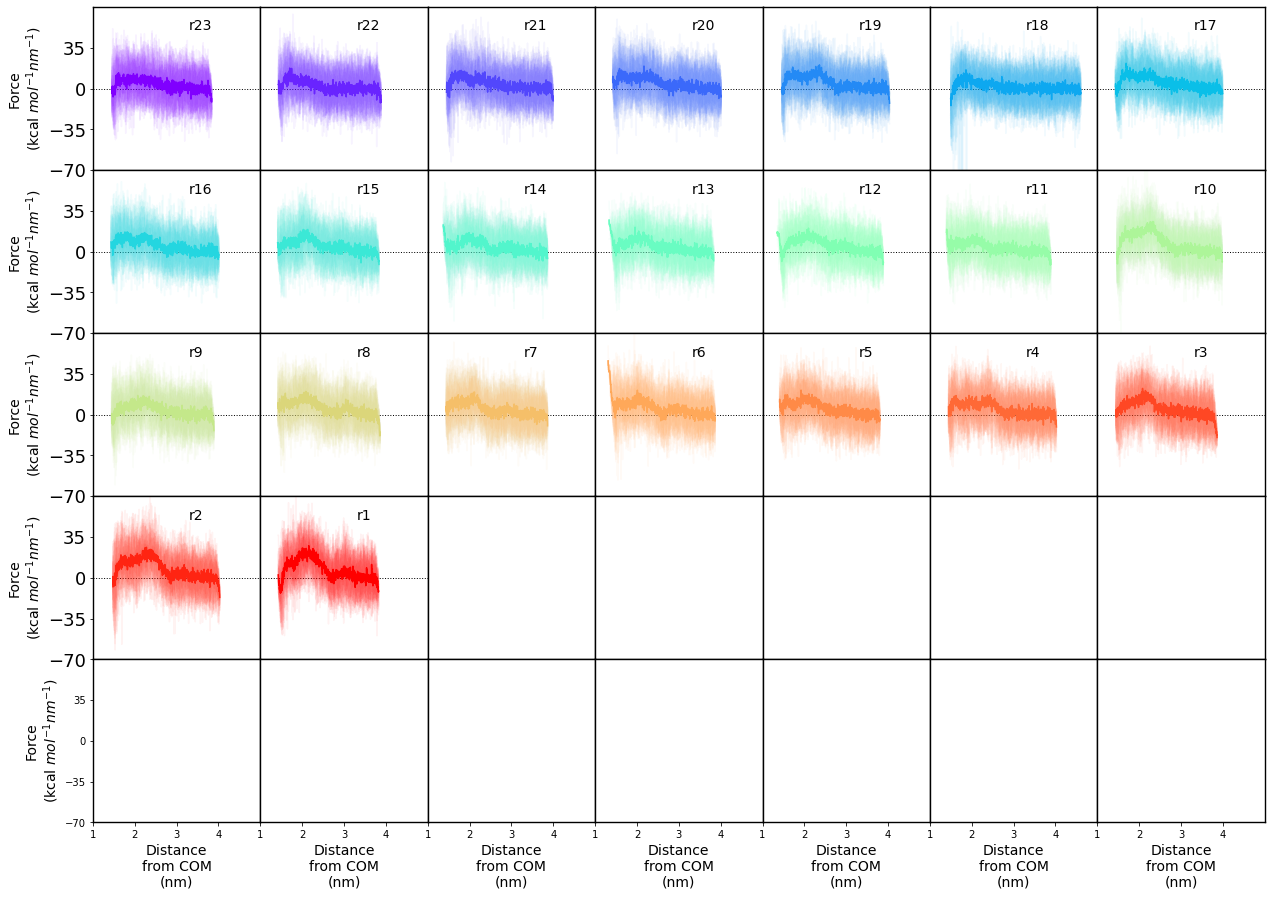

In [10]:
nc = 7
nr = 5
fig, axs = plt.subplots(figsize=(nc*3,nr*3), ncols=nc, nrows=nr, subplot_kw={'xlim':(1,5), 'ylim':(-70,70), 'xticks':[], 'yticks':[]}, gridspec_kw={'wspace':0, 'hspace':0})
for ax, X, F, c, name in zip(axs.flatten(), Xs, Fs, DATA.Color, DATA.index):
    ax.axhline(y=0, lw=1, c='k', ls=':')
    ax.tick_params(labelsize=Z)
    for f in F.T:
        ax.plot(X, f, alpha=0.05, color=c)
    mean_f = np.mean(F, axis=1)
    ax.plot(X, mean_f, color=c)
    ax.text(3.3,50, name, fontsize=Z-4)
for ax in axs[:,0]:
    ax.set_yticks([-70,-35,0,35])
    ax.set_ylabel("Force\n"+r"(kcal $mol^{-1}nm^{-1}$)", fontsize=Z-4)
for ax in axs[-1,:]:
    ax.set_xticks([1,2,3,4])
    ax.set_xlabel("Distance\nfrom COM\n(nm)", fontsize=Z-4)
plt.show()
plt.close()

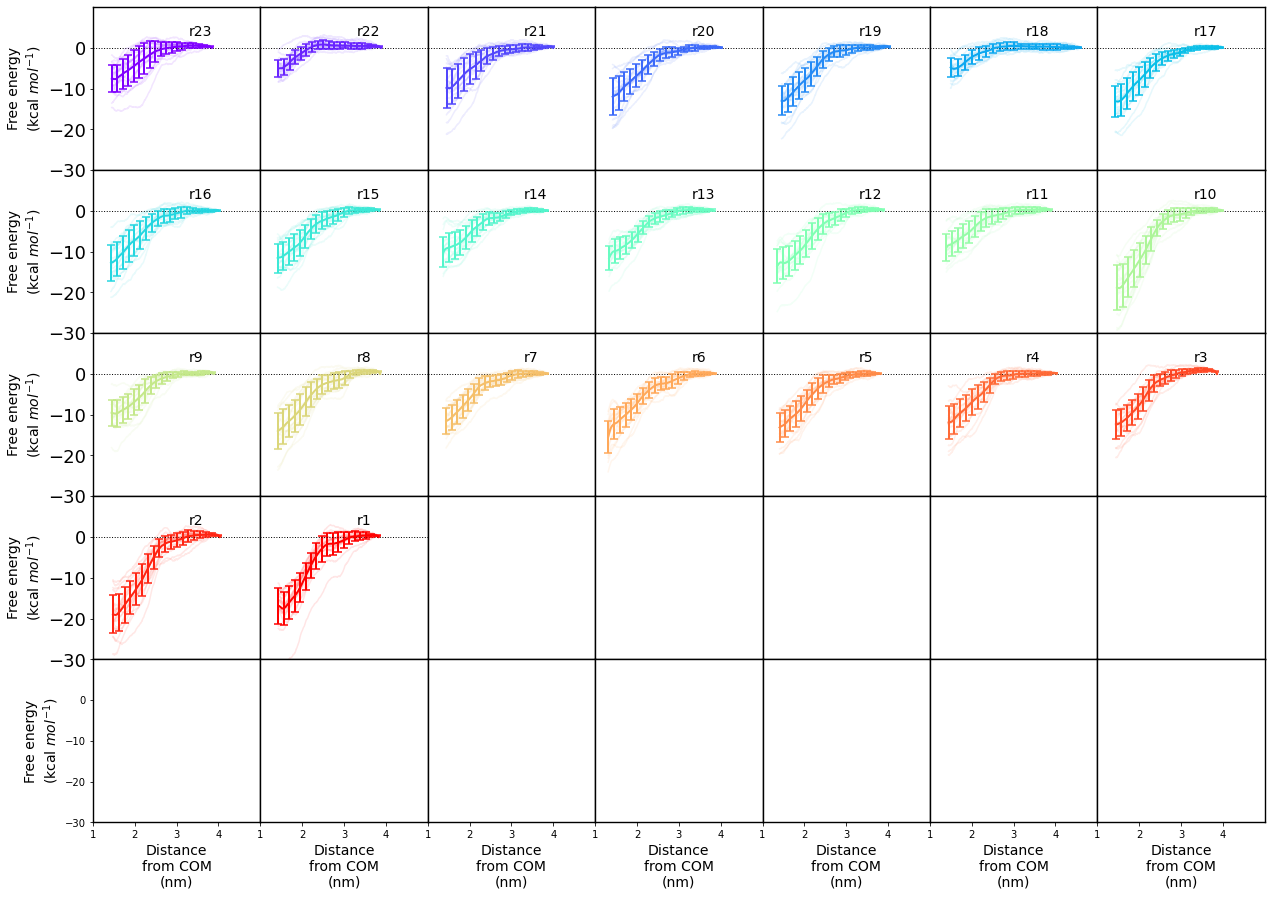

In [11]:
nc = 7
nr = 5
fig, axs = plt.subplots(figsize=(nc*3,nr*3), ncols=nc, nrows=nr, subplot_kw={'xlim':(1,5), 'ylim':(-30,10), 'xticks':[], 'yticks':[]}, gridspec_kw={'wspace':0, 'hspace':0})
for ax, X, G, c, name in zip(axs.flatten(), Xs, Gs, DATA.Color, DATA.index):
    ax.axhline(y=0, lw=1, c='k', ls=':')
    ax.tick_params(labelsize=Z)
    for g in G.T:
        ax.plot(X, g, alpha=0.1, color=c)
    mean_g = np.mean(G, axis=1)
    #std_g = np.std(G, axis=1)/(len(G))**0.5 #ste
    std_g = np.std(G, axis=1) #standard deviation
    ax.errorbar(X, mean_g, yerr=std_g, color=c, errorevery=50, capsize=4, capthick=1.5, lw=2)
    ax.text(3.3,3, name, fontsize=Z-4)
for ax in axs[:,0]:
    ax.set_yticks([-30,-20,-10,0])
    ax.set_ylabel("Free energy\n"+r"(kcal $mol^{-1}$)", fontsize=Z-4)
for ax in axs[-1,:]:
    ax.set_xticks([1,2,3,4])
    ax.set_xlabel("Distance\nfrom COM\n(nm)", fontsize=Z-4)
plt.show()
plt.close()

In [12]:
def metric_gridsearch_dg(j_space, data=DATA):
    accuracy, sensitivity, specificity = [], [], []
    for j in j_space:
        pred_active = (DATA.DG_Mean > j).astype('float')
        active = data.Active.astype('float')
        tp, tn, fp, fn = proc.confusion_matrix_sfu(active, pred_active)
        accuracy.append((tp+tn)/(tp+tn+fp+fn))
        sensitivity.append(tp/(tp+fn))
        specificity.append(tn/(tn+fp))
    accuracy, sensitivity, specificity = np.array(accuracy), np.array(sensitivity), np.array(specificity)
    return accuracy, sensitivity, specificity
dg_thres = np.linspace(0,30, 100)
acc, sens, spec = metric_gridsearch_dg(dg_thres, DATA)
#opt_array = 0.5*(sens+spec)
#decide_array = acc*1
#opt_array = acc*1
#decide_array = 0.5*(sens+spec)
opt_array = (acc+sens+spec)
decide_array = (acc+sens+spec)
best_ndxs = np.where(opt_array==np.max(opt_array))[0]
best_ndx = best_ndxs[0]
#best_ndx = 32 #triple point
best_dg = dg_thres[best_ndx]
print("Equivalent positions (i): ", best_ndxs)
print("Chosen index: ", best_ndx)
print("Best accuracy: {:.2f}".format(acc[best_ndx]))
print("Best sensitivity: {:.2f}".format(sens[best_ndx]))
print("Best specificity: {:.2f}".format(spec[best_ndx]))
print("Best free energy threshold: {:.2f} kcal/mol".format(best_dg))
bind_scores = np.array([l for listita in list(DATA.Score[DATA.Active==True].values) for l in listita])
unbind_scores = np.array([l for listita in list(DATA.Score[DATA.Active==False].values) for l in listita])
ks, p_val = ks_2samp(bind_scores, unbind_scores)

Equivalent positions (i):  [45]
Chosen index:  45
Best accuracy: 0.78
Best sensitivity: 0.89
Best specificity: 0.40
Best free energy threshold: 13.64 kcal/mol


In [13]:
print(p_val)

2.0388958388295464e-07


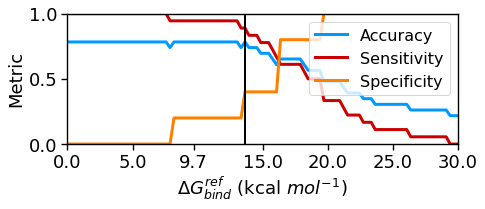

In [14]:
fig = plt.figure(figsize=(7,2.4))
ax = plt.axes()
ax.set_xlim(0,30)
ax.set_ylim(0,1)
ax.plot(dg_thres, acc, lw=3, label='Accuracy', c=(0,0.6,1))
ax.plot(dg_thres, sens, lw=3, label='Sensitivity', c=(0.8,0,0))
ax.plot(dg_thres, spec, lw=3, label='Specificity', c=(1.0,0.5,0))
ax.set_xlabel(r'$\Delta G_{bind}^{ref}$ (kcal $mol^{-1}$)', fontsize=Z)
ax.set_ylabel('Metric', fontsize=Z)
ax.legend(fontsize=Z-2, loc='upper right')
ax.tick_params(labelsize=Z, size=6, width=1.4)
ax.set_xticks([0,5,9.697,15,20,25,30])
ax.set_xticklabels([0.0,5.0,9.7,15.0,20.0,25.0,30.0])
ax.set_yticks
ax.axvline(best_dg, c='k', lw=2)
plt.savefig("S36/Accuracy/Metrics.png", format='png', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig("S36/Accuracy/Metrics.svg", format='svg', bbox_inches='tight', transparent=True)
svg2emf("S36/Accuracy/Metrics.svg")
plt.show()
plt.close()

In [15]:
from importlib import reload
reload(pp)

<module 'DEPENDENCIES.plot_performance' from 'C:\\Users\\sfranco\\Documents\\PhD\\Data\\ThiolScreening\\Mixtures\\DEPENDENCIES\\plot_performance.py'>

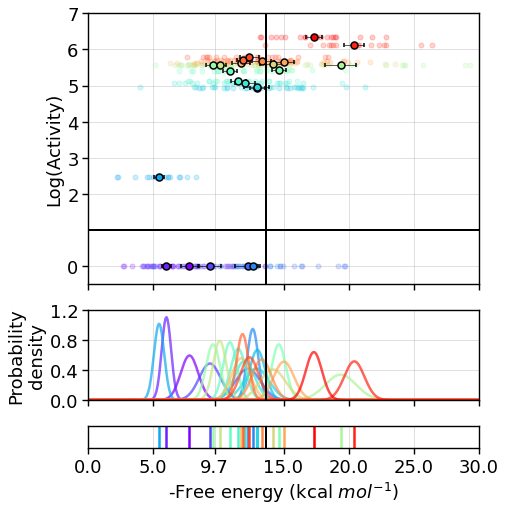

In [16]:
kwargs = {'xlim':(0,30), 'xlabel':'-Free energy '+r'(kcal $mol^{-1}$)', 'xticks':[0,5,9.7,15,20,25,30],
          'pdf_lim' : (0,1.2), 'pdf_ticks':[0,0.4,0.8,1.2],
          'distr_lim':(0,0.2), 'distr_ticks':np.linspace(0,0.2,5),
          'path':'S36/Accuracy', 'plot_str':'acc', 
          'figsize':(7,8), 'svg':False}

pp.plot_score_distribution(best_dg, dg_thres, data=DATA, kwargs=kwargs)
#pp.plot_score_rank(best_dg, dg_thres, data=DATA, kwargs=kwargs)

# True positives

In [17]:
proc.true_positives(best_dg, DATA)

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Score,DG_Mean,DG_Std,System
r19,16,20,45000.0,0.0,18,0,0,4.653213,0.000000,0.000000,"[0.3, 0.95, 0.81, 1.0]",True,"[14.00322666953547, 11.625399540120094, 12.606...",12.094474,0.390246,N16A20
r17,2,11,85000.0,15000.0,16,2,0,4.929419,0.070581,0.084321,"[0.43, 0.99, 0.74, 1.0]",True,"[16.313033785994197, 15.266570341583371, 11.10...",12.987418,0.598511,N2A11
r16,2,10,93000.0,12000.0,15,1,1,4.968483,0.052706,0.059998,"[0.5, 1.0, 0.7, 1.0]",True,"[8.787232067800229, 12.397592631713772, 14.193...",12.941394,0.953455,N2A10
r15,1,9,120000.0,20000.0,14,1,2,5.079181,0.066947,0.079181,"[0.57, 0.99, 0.67, 1.0]",True,"[13.288001067941005, 10.418017349372178, 14.50...",12.006746,0.766250,N1A9
r14,1,8,130000.0,20000.0,13,0,1,5.113943,0.062148,0.072551,"[0.64, 0.98, 0.63, 1.0]",True,"[12.3797525869843, 9.243238559463526, 12.25649...",11.514691,0.586111,N1A8
r13,1,7,260000.0,60000.0,12,1,0,5.414973,0.090177,0.113943,"[0.7, 0.95, 0.59, 1.0]",True,"[10.841493433329319, 9.672933280858, 11.149675...",10.883874,0.518881,N1A7
r12,1,13,270000.0,30000.0,11,0,1,5.431364,0.045757,0.051153,"[0.77, 0.91, 0.54, 1.0]",True,"[14.625526068169963, 17.170591876667174, 15.58...",14.636564,0.539080,N1A13
r10,3,19,360000.0,10000.0,9,3,1,5.556303,0.011899,0.012234,"[0.9, 0.81, 0.45, 1.0]",True,"[20.51208955764064, 14.531952783555207, 12.768...",19.388156,1.182966,N3A19
r9,1,15,370000.0,0.0,8,2,1,5.568202,0.000000,0.000000,"[0.97, 0.74, 0.41, 1.0]",True,"[13.161793645950192, 10.87543647997276, 10.032...",10.095190,0.505552,N1A15
r8,1,12,390000.0,30000.0,7,1,3,5.591065,0.032185,0.034762,"[1.0, 0.66, 0.36, 1.0]",True,"[22.81981582484305, 8.876653784840615, 8.16589...",14.176649,0.978451,N1A12


In [31]:
len(proc.true_positives(best_dg, DATA))

17

# False positives

In [18]:
proc.false_positives(best_dg, data=DATA)

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Score,DG_Mean,DG_Std,System
r24,3,11,0.0,0.0,23,7,1,0.0,0.0,0.0,"[0.04, 0.66, 0.93, 1.0]",False,"[8.61962856575134, 8.266370530786512, 5.087257...",12.265111,0.957475,N3A11
r23,3,18,0.0,0.0,22,8,0,0.0,0.0,0.0,"[0.03, 0.74, 0.91, 1.0]",False,"[9.178812658688003, 12.993237730165722, 14.755...",12.635289,0.421579,N3A18


# False negatives

In [19]:
proc.false_negatives(best_dg, data=DATA)

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Score,DG_Mean,DG_Std,System
r22,6,20,120.0,5.0,21,0,0,2.079181,0.017729,0.018483,"[0.1, 0.81, 0.89, 1.0]",True,"[2.1228455468097915, 6.92519236176413, 4.01954...",4.657588,0.507745,N6A20
r21,15,20,300.0,0.0,20,0,0,2.477121,0.000000,0.000000,"[0.17, 0.87, 0.87, 1.0]",True,"[6.093380671561805, 4.5388658465979415, 7.0610...",5.439625,0.392944,N15A20
r20,7,20,1100.0,0.0,19,0,0,3.041393,0.000000,0.000000,"[0.23, 0.91, 0.84, 1.0]",True,"[4.93432236262952, 5.82248175075563, 3.9543907...",6.731246,0.579584,N7A20
r18,13,20,50000.0,0.0,17,0,0,4.698970,0.000000,0.000000,"[0.36, 0.98, 0.78, 1.0]",True,"[5.101417551535434, 2.0443619689022094, 4.4176...",5.428926,0.661409,N13A20
r11,1,1,360000.0,0.0,10,2,0,5.556303,0.000000,0.000000,"[0.83, 0.87, 0.5, 1.0]",True,"[10.220058325203162, 9.845147922665086, 10.947...",9.586464,0.537521,N1A1


# True negatives

In [20]:
proc.true_negatives(best_dg, data=DATA)

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Score,DG_Mean,DG_Std,System
r31,8,20,0.0,0.0,30,0,8,0.0,0.0,0.0,"[0.5, 0.0, 1.0, 1.0]",False,"[1.8082644590457577, 3.601530922698876, 6.2884...",5.307877,0.497413,N8A20
r30,14,20,0.0,0.0,29,1,7,0.0,0.0,0.0,"[0.44, 0.1, 1.0, 1.0]",False,"[5.003626871298479, 7.4265624563192665, 4.7403...",5.512428,0.368536,N14A20
r29,9,20,0.0,0.0,28,2,6,0.0,0.0,0.0,"[0.37, 0.21, 0.99, 1.0]",False,"[4.3533108884663525, 5.933827031789486, 8.7490...",5.756103,0.675444,N9A20
r28,6,21,0.0,0.0,27,3,5,0.0,0.0,0.0,"[0.3, 0.3, 0.99, 1.0]",False,"[3.4480756091748703, 4.087042567332594, 2.2702...",4.332460,0.400127,N6A21
r27,1,16,0.0,0.0,26,4,4,0.0,0.0,0.0,"[0.23, 0.41, 0.98, 1.0]",False,"[9.288041475872392, 4.282236978039926, 2.73936...",7.775956,0.673691,N1A16
r26,1,17,0.0,0.0,25,5,3,0.0,0.0,0.0,"[0.17, 0.49, 0.97, 1.0]",False,"[4.550628335473629, 7.2270197983770075, 6.9246...",6.002603,0.361970,N1A17
r25,3,10,0.0,0.0,24,6,2,0.0,0.0,0.0,"[0.1, 0.59, 0.95, 1.0]",False,"[8.825919849191028, 12.486030550199187, 9.7288...",9.344124,0.821323,N3A10


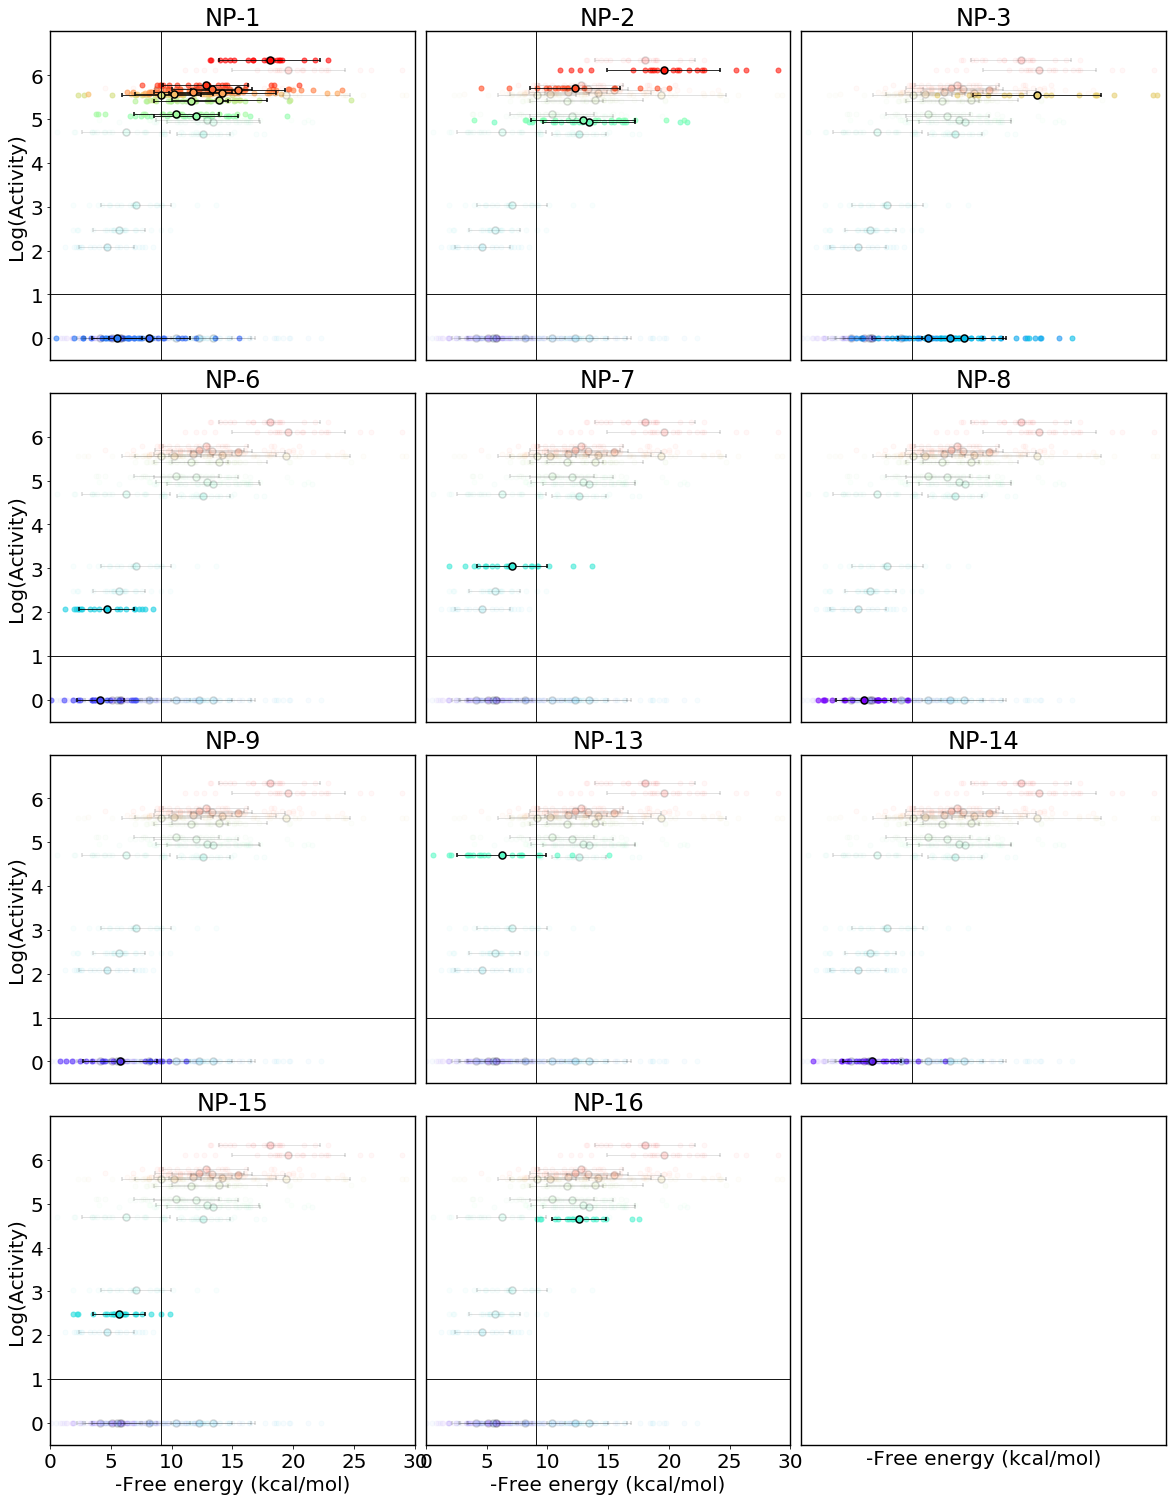

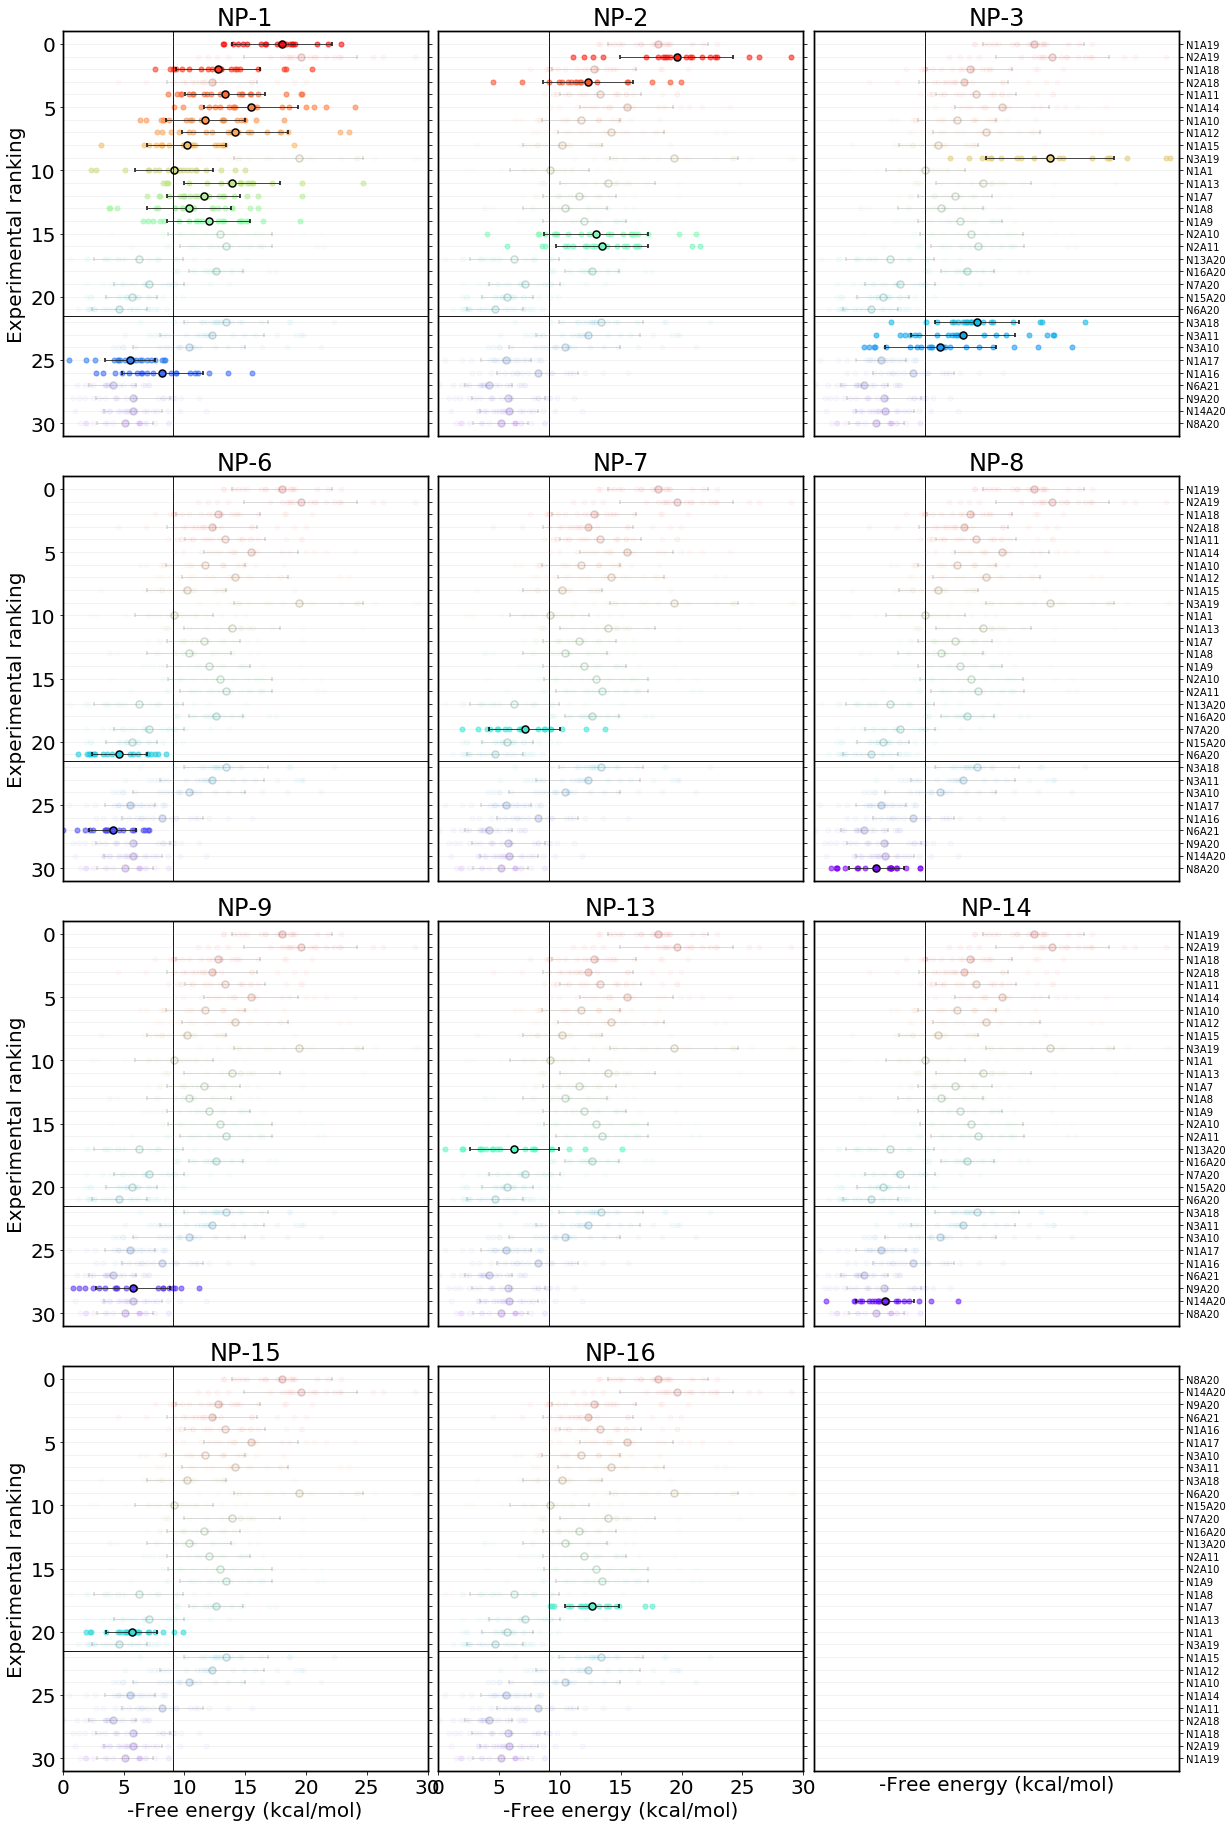

In [18]:
pp.plot_np_dependence(best_dg, data=DATA, kwargs=kwargs)
pp.plot_np_dependence_rank(best_dg, data=DATA, kwargs=kwargs)

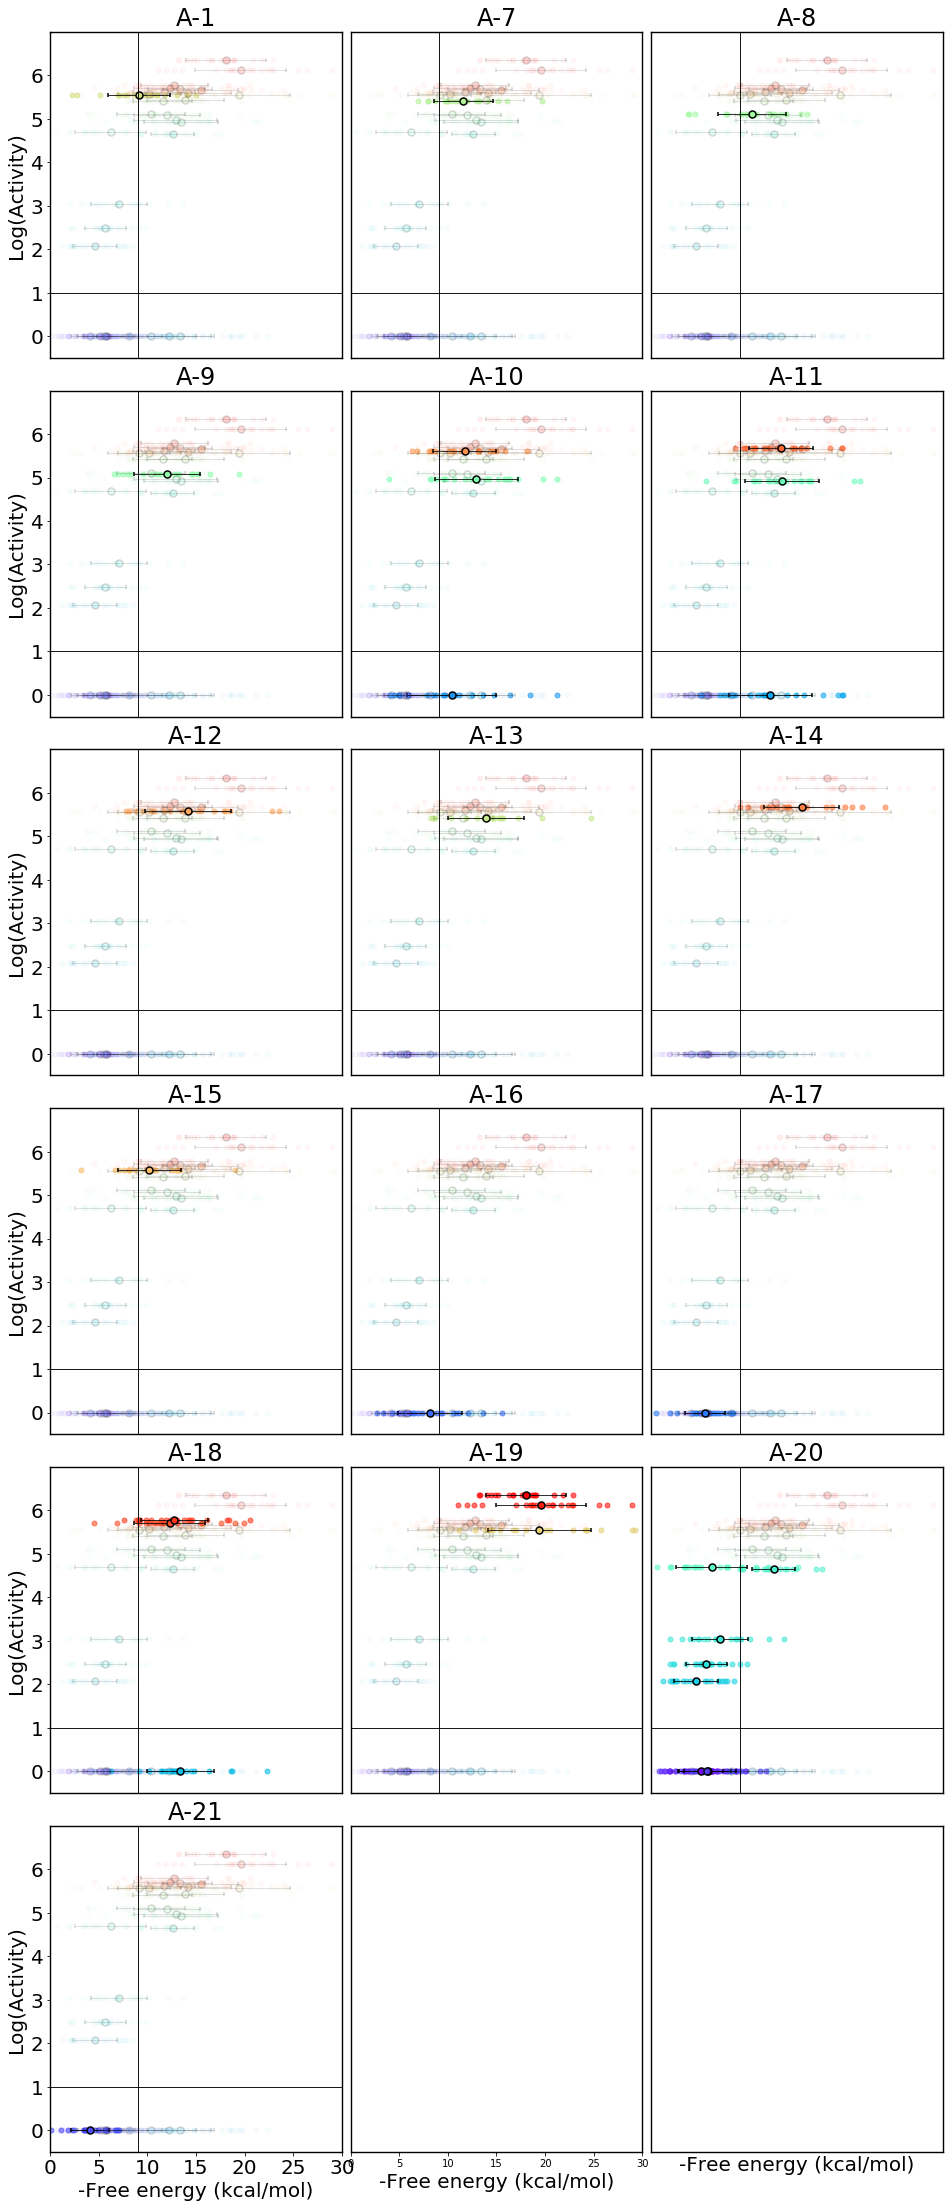

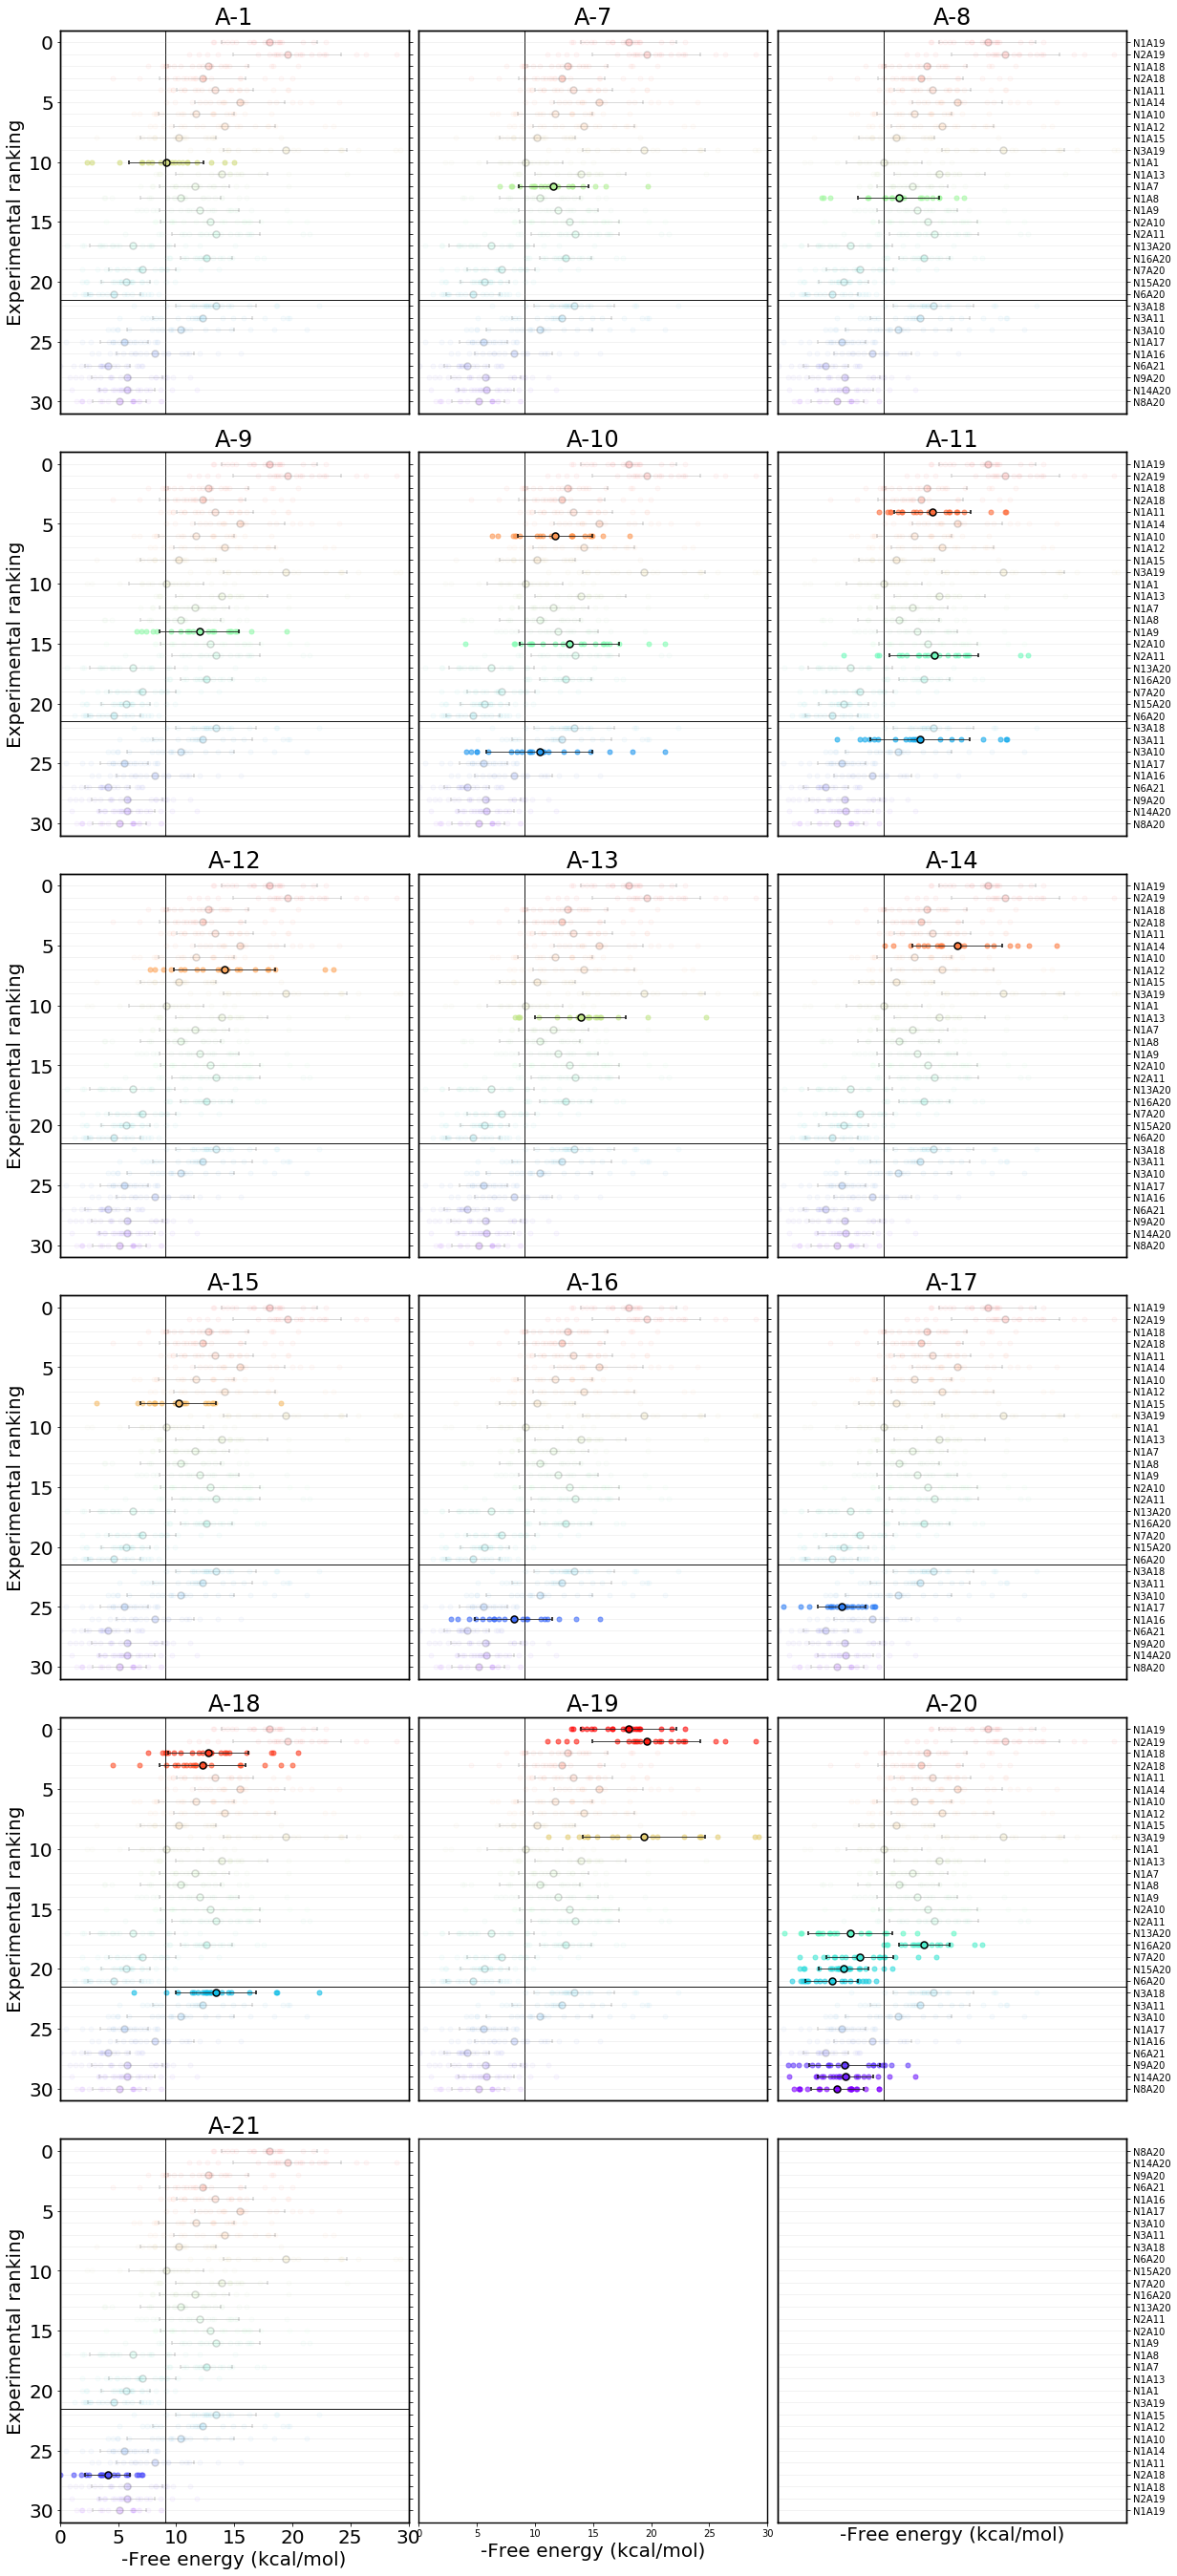

In [19]:
pp.plot_an_dependence(best_dg, data=DATA, kwargs=kwargs)
pp.plot_an_dependence_rank(best_dg, data=DATA, kwargs=kwargs)

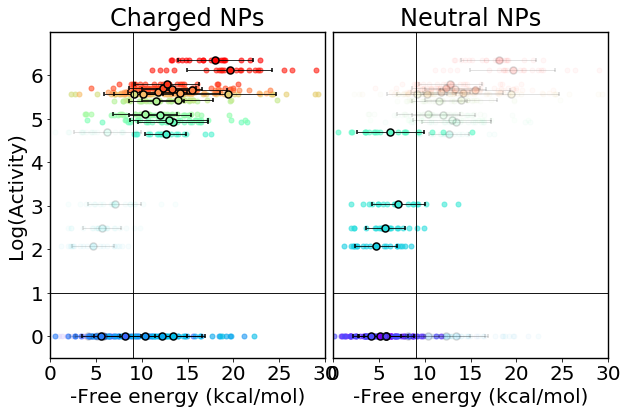

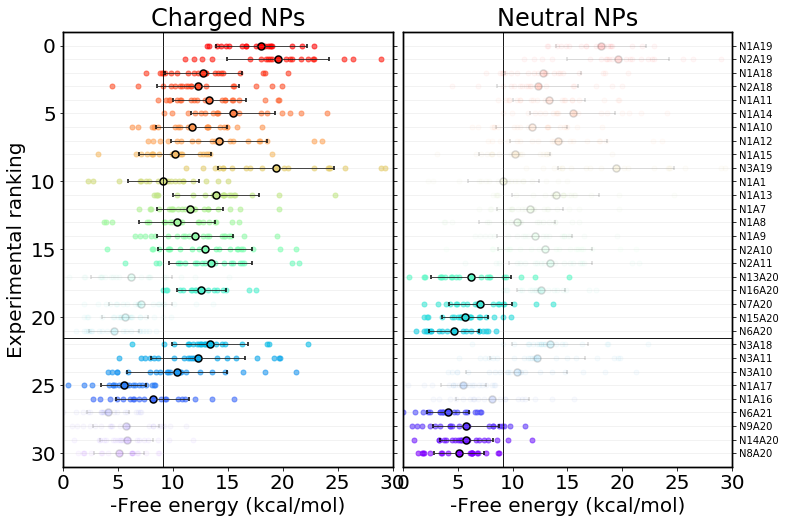

In [20]:
pp.plot_npcharge_dependence(best_dg, data=DATA, kwargs=kwargs)
pp.plot_npcharge_dependence_rank(best_dg, data=DATA, kwargs=kwargs)

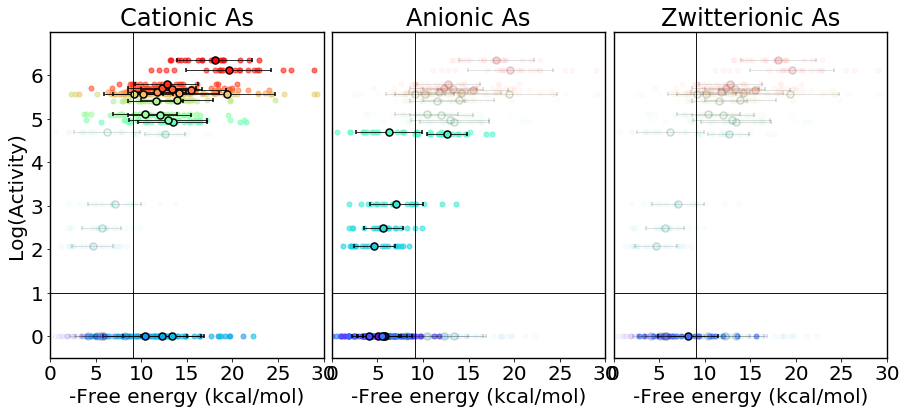

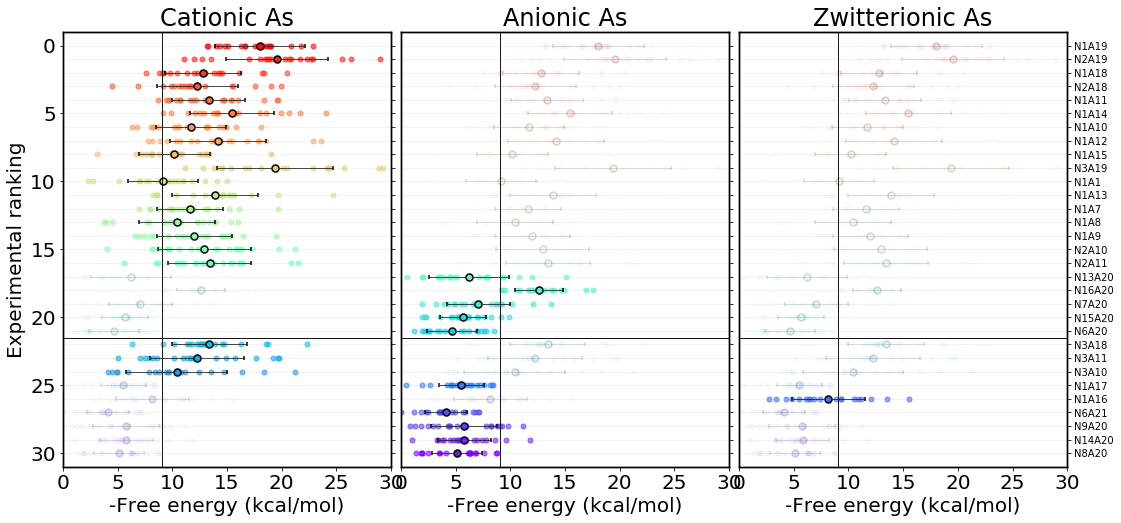

In [21]:
pp.plot_ancharge_dependence(best_dg, data=DATA, kwargs=kwargs)
pp.plot_ancharge_dependence_rank(best_dg, data=DATA, kwargs=kwargs)

In [28]:
from importlib import reload

In [39]:
reload(pp)

<module 'DEPENDENCIES.plot_performance' from 'C:\\Users\\sfranco\\Documents\\PhD\\Data\\ThiolScreening\\Mixtures\\DEPENDENCIES\\plot_performance.py'>

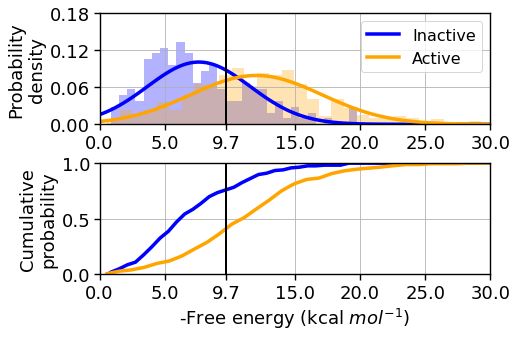

In [40]:
kwargs = {'xlim':(0,30), 'xlabel':'-Free energy '+r'(kcal $mol^{-1}$)', 'xticks':[0,5,9.7,15,20,25,30],
          'pdf_lim' : (0,1.2), 'pdf_ticks':[0,0.4,0.8,1.2],
          'distr_lim':(0,0.18), 'distr_ticks':np.linspace(0,0.18,4),
          'path':'S36/Accuracy', 'plot_str':'acc', 
          'figsize':(7,4.8), 'svg':False}

pp.plot_distributions(dg_thres, best_dg, bind_scores, unbind_scores, kwargs=kwargs)

In [30]:
np.exp(-9.7/0.596)/10**-6

0.08546424075823233

In [26]:
0.592/298*300

0.595973154362416